In [1]:
%load_ext autoreload
%autoreload 2

In [205]:
import cv2
import torch
import torchvision

import pandas as pd
import numpy as np
import seaborn as sns 
import albumentations as A
import matplotlib.pyplot as plt

from tqdm.cli import tqdm
from pathlib import Path
from sklearn.model_selection import StratifiedKFold
from src.data import EyeDataset
from src.utils import load_splits
from src.utils import custom_to_std_tensor
from src.utils import custom_to_std_tensor_with_train_mask
from src.utils import denormalize
from src.utils import eye_blend
from src.utils import EYE_MEAN, EYE_STD 
from src.utils import TRAIN_MASKS_MEAN, TRAIN_MASKS_STD

In [3]:
data_folder = Path("data")
folds_folder = Path("folds")

test_df = pd.read_csv(data_folder / "test.csv")
train_df, val_df = load_splits(folds_folder)

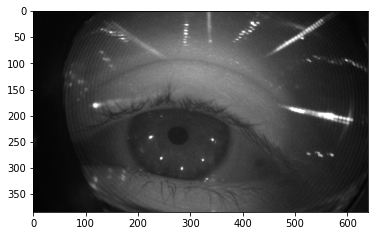

In [4]:
transfrom = A.Compose([
#     A.Resize(100, 100),
    A.Resize(384,  640),
    A.HorizontalFlip(),
    custom_to_std_tensor,
])

dataset = EyeDataset(test_df, "test", transfrom)
img, *_ = dataset[5]

img_arr = np.array(torchvision.transforms.functional.to_pil_image(denormalize(img)))

plt.figure(figsize=(6, 10))
plt.imshow(img_arr, cmap="gray")

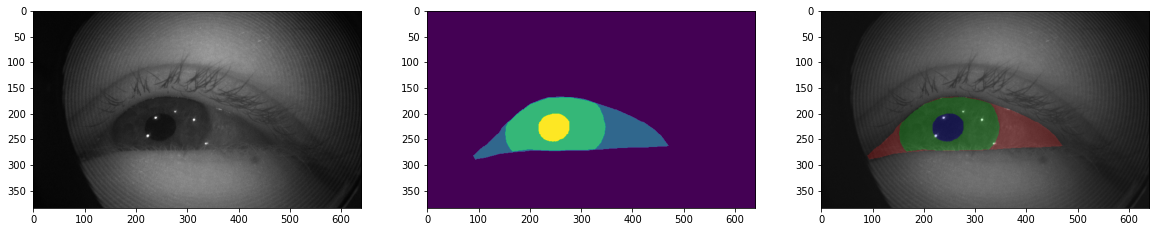

In [5]:
transform = A.Compose([
#     A.Resize(100, 100),
    A.Resize(384,  640),
    A.HorizontalFlip(),
    custom_to_std_tensor,
])

dataset = EyeDataset(train_df, "train", transform)

img, mask = dataset[3]

img_arr = np.array(torchvision.transforms.functional.to_pil_image(denormalize(img)))

mask_arr = mask.numpy()
blend = eye_blend(img, mask)

plt.figure(figsize=(20, 10))
plt.subplot(1, 3, 1)
plt.imshow(img_arr, cmap="gray")
plt.subplot(1, 3, 2)
plt.imshow(mask_arr)
plt.subplot(1, 3, 3)
plt.imshow(blend)

In [203]:
class EyeDatasetV2(torch.utils.data.Dataset):
    def __init__(
        self, 
        df,
        mode,
        transform=None,
        return_pos=False,
        train_df=None
    ):
        self.df = df
        self.mode = mode
        self.transform = transform
        self.return_pos = return_pos
        self.train_df = train_df
    
    def __getitem__(self, idx):
        item = self.df.iloc[idx]

        img = cv2.imread(item.img_filename, cv2.IMREAD_GRAYSCALE)
        
        if self.train_df is not None:
            train_masks_df = self.train_df[
                (self.train_df.seq == item.seq) &
                (self.train_df.order != item.order) & 
                (self.train_df.mask_filename.notna())
            ]
            train_masks = []
            for train_mask_filename in train_masks_df.mask_filename:
                train_masks.append(np.load(train_mask_filename))
            train_masks_channel = np.mean(train_masks, axis=0)
            train_masks_channel = (train_masks_channel * 50).astype(np.uint8)
            img = np.transpose(np.stack((img, train_masks_channel)), (1, 2, 0))
        
        mask = None        
        if self.mode in ["train", "val"]:
            mask = np.load(item.mask_filename)
            
        if self.transform is not None:
            transformed = self.transform(
                image=img,
                mask=mask
            )
            img = transformed["image"]
            mask = transformed["mask"]

        output = [img, ]
        
        if mask is not None:
            output.append(mask)
        
        if self.return_pos:
            output.append((item.seq, item.order))
        
        return  output

    
    def __len__(self):
        return len(self.df)


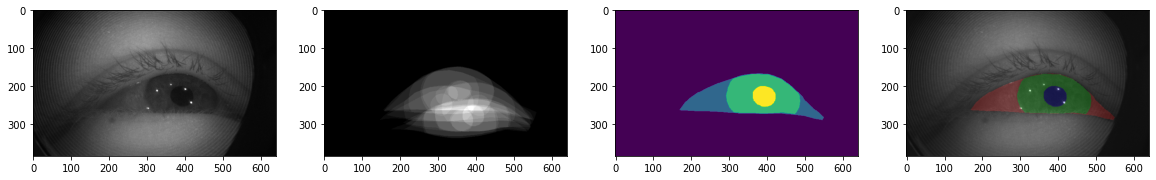

In [206]:
transform = A.Compose([
#     A.Resize(100, 100),
    A.Resize(384,  640),
    A.HorizontalFlip(),
    custom_to_std_tensor_with_train_mask,
])

dataset = EyeDatasetV2(train_df, "train", transform, train_df=train_df)

img, mask = dataset[3]

img_arr = np.array(torchvision.transforms.functional.to_pil_image(denormalize(
    img,
    mean=EYE_MEAN + TRAIN_MASKS_MEAN,
    std=EYE_STD + TRAIN_MASKS_STD,
)))

mask_arr = mask.numpy()
blend = eye_blend(img[0].unsqueeze(0), mask)

plt.figure(figsize=(20, 10))
plt.subplot(1, 4, 1)
plt.imshow(img_arr[:, :, 0], cmap="gray")
plt.subplot(1, 4, 2)
plt.imshow(img_arr[:, :, 1], cmap="gray")
plt.subplot(1, 4, 3)
plt.imshow(mask_arr)
plt.subplot(1, 4, 4)
plt.imshow(blend)